# 1. Preparación de datos

## Importar librerías

In [34]:
import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import cv2
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

## Conexiones

In [35]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cargar datos

In [36]:
# Cargar bases de datos procesadas
x_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/cod/A3_helath/data/salidas/y_test.pkl')

In [37]:
# Ver las formas (número de imágenes, alto, ancho, canales, etc.)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (5712, 151, 150, 3)
y_train shape: (5712, 1)
x_test shape: (1311, 151, 150, 3)
y_test shape: (1311, 1)


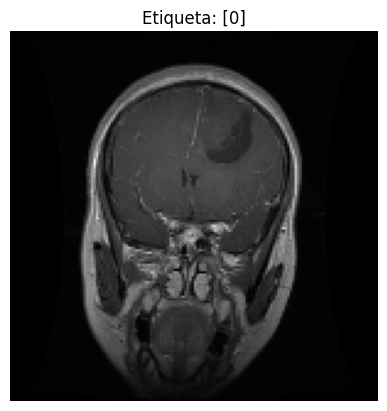

In [38]:
# Mostrar la imagen
plt.imshow(x_train[999])
plt.title(f"Etiqueta: {y_train[999]}")
plt.axis('off')
plt.show()

## Preparación de datos

In [39]:
# Conversión a float32 para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [40]:
# Escalado entre 0 y 1
x_train /= 255
x_test /= 255

In [41]:
# Visualizar forma de las imagenes para luego convertir a 1D
print("Shape x_train:", x_train.shape)
print("Shape x_test:", x_test.shape)

Shape x_train: (5712, 151, 150, 3)
Shape x_test: (1311, 151, 150, 3)


In [42]:
# Convertir a 1D
x_train2 = x_train.reshape(x_train.shape[0], -1)
x_test2 = x_test.reshape(x_test.shape[0], -1)

x_train2.shape
x_test2.shape

x_train2[1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

<ipython-input-43-67243097c8cb>:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Etiqueta: {int(y_train[1])}")


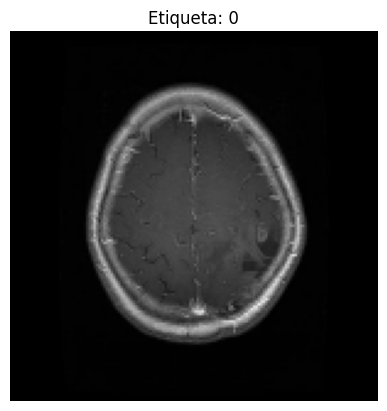

In [43]:
# Reconstruir la forma original (151 alto, 150 ancho, 3 canales)
img = x_train2[0].reshape((151, 150, 3))

# Mostrar la imagen
plt.imshow(img)
plt.title(f"Etiqueta: {int(y_train[1])}")
plt.axis('off')
plt.show()

#2. Preprocesamiento  para modelo tradicional

## Random Forest

In [44]:
# Entrenar el modelo
rf = RandomForestClassifier()
rf.fit(x_train2, y_train.ravel())

# Entrenamos el modelo Random Forest utilizando los datos de entrenamiento.
# Se usa .ravel() para convertir y_train de un arreglo de 2 dimensiones (n,1) a 1 dimensión (n,)
# ya que RandomForestClassifier espera un vector unidimensional como etiquetas.


# Predicciones para train
pred_train = rf.predict(x_train2)
print(metrics.classification_report(y_train, pred_train))

# Probabilidades para train (todas las clases)
pred_train_proba = rf.predict_proba(x_train2)
roc_auc_train = metrics.roc_auc_score(y_train, pred_train_proba, multi_class='ovr')
print("ROC AUC train:", roc_auc_train)

# Predicciones para test
pred_test = rf.predict(x_test2)
# Capturar el classification_report y almacenarlo
report_rf = metrics.classification_report(y_test, pred_test, output_dict=True)
print(metrics.classification_report(y_test, pred_test))

# Almacenar accuracy y AUC en variables
rf_accuracy_test = report_rf['accuracy']
pred_test_proba = rf.predict_proba(x_test2)
rf_auc_test = metrics.roc_auc_score(y_test, pred_test_proba, multi_class='ovr')

print("ROC AUC test:", rf_auc_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1321
           1       1.00      1.00      1.00      1339
           2       1.00      1.00      1.00      1457
           3       1.00      1.00      1.00      1595

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712

ROC AUC train: 1.0
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       300
           1       0.85      0.93      0.89       306
           2       0.95      0.97      0.96       300
           3       0.98      1.00      0.99       405

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311

ROC AUC test: 0.9915045360112331


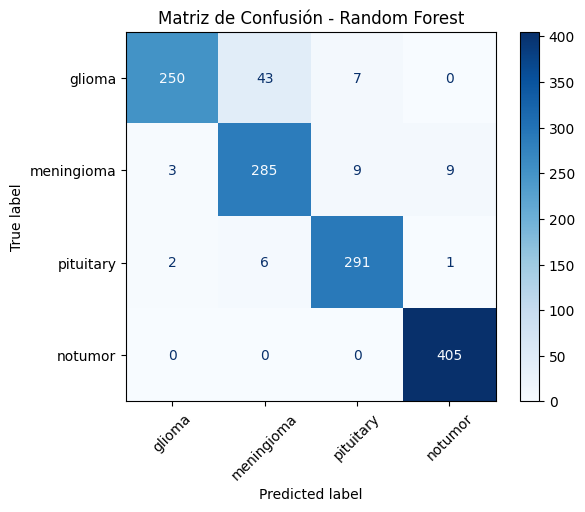

In [45]:
# Obtener las predicciones sobre el conjunto de prueba
pred_test = rf.predict(x_test2)

# Definir las etiquetas de las clases
class_labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Matriz de confusión
cm = confusion_matrix(y_test, pred_test, labels=[0, 1, 2, 3])

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión - Random Forest")
plt.show()

#3. Modelos de redes neuronales

## Redes Neuronales NN - Multiclase

In [63]:
# Etiquetas como enteros (0, 1, 2, ...)
y_train = np.array(y_train).astype('int32').flatten()
y_test = np.array(y_test).astype('int32').flatten()


# Cantidad de clases
num_classes = len(np.unique(y_train))

# Pesos de clase
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

# Modelo para multiclase
fc_model_multi = Sequential()
fc_model_multi.add(Flatten(input_shape=x_train.shape[1:]))
fc_model_multi.add(Dense(128, activation='relu'))
fc_model_multi.add(Dense(64, activation='relu'))
fc_model_multi.add(Dense(num_classes, activation='softmax'))  # salida multiclase

# Compilar modelo
fc_model_multi.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',  # <- multiclase
                 metrics=['accuracy'])

# Guardar el mejor modelo
checkpoint = ModelCheckpoint("mejor_modelo.h5", monitor="val_accuracy", save_best_only=True, mode='max', verbose=1)

# Entrenamiento
history_nn_multi = fc_model_multi.fit(x_train, y_train,
             batch_size=100,
             epochs=10,
             validation_data=(x_test, y_test),
             callbacks=[checkpoint],
             class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4128 - loss: 3.2781
Epoch 1: val_accuracy improved from -inf to 0.71243, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.4150 - loss: 3.2542 - val_accuracy: 0.7124 - val_loss: 0.8366
Epoch 2/10
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7323 - loss: 0.6961
Epoch 2: val_accuracy improved from 0.71243 to 0.75210, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.7338 - loss: 0.6939 - val_accuracy: 0.7521 - val_loss: 0.6621
Epoch 3/10
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8203 - loss: 0.5271
Epoch 3: val_accuracy did not improve from 0.75210
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8200 - loss: 0.5276 - val_accuracy: 0.7033 - val_loss: 0.7379
Epoch 4/10
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7837 - loss: 0.5581
Epoch 4: val_accuracy improved from 0.75210 to 0.78795, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.7854 - loss: 0.5556 - val_accuracy: 0.7879 - val_loss: 0.5818
Epoch 5/10
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8678 - loss: 0.3952
Epoch 5: val_accuracy did not improve from 0.78795
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8678 - loss: 0.3962 - val_accuracy: 0.7864 - val_loss: 0.5529
Epoch 6/10
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8701 - loss: 0.3592
Epoch 6: val_accuracy did not improve from 0.78795
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8695 - loss: 0.3610 - val_accuracy: 0.7857 - val_loss: 0.5340
Epoch 7/10
54/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8851 - loss: 0.3457
Epoch 7: val_accuracy did not improve from 0.78795
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8862 - loss: 0.3434 - val_accuracy: 0.7574 - val_loss: 0.6080
Epoch 8/10
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8679 - loss: 0.3466
Epoch 8: val_accuracy improved from 0.7879

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8688 - loss: 0.3452 - val_accuracy: 0.8284 - val_loss: 0.5086
Epoch 9/10
57/58 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9209 - loss: 0.2489
Epoch 9: val_accuracy improved from 0.82838 to 0.84134, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9208 - loss: 0.2489 - val_accuracy: 0.8413 - val_loss: 0.4194
Epoch 10/10
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9327 - loss: 0.2136
Epoch 10: val_accuracy improved from 0.84134 to 0.88863, saving model to mejor_modelo.h5


58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9329 - loss: 0.2130 - val_accuracy: 0.8886 - val_loss: 0.3440


In [64]:
# Obtener las probabilidades de predicción para el modelo de red neuronal multiclase en el conjunto de prueba
# El modelo con activación softmax en la capa de salida ya produce probabilidades
y_pred_proba_nn_multi = fc_model_multi.predict(x_test)

# Calcular el AUC utilizando las probabilidades predichas y las etiquetas reales
# Usamos multi_class='ovr' y average='macro' para manejar clasificación multiclase
try:
    roc_auc_nn_multi = roc_auc_score(y_test, y_pred_proba_nn_multi, multi_class='ovr', average='macro')
    print(f"AUC para el modelo de red neuronal multiclase en el conjunto de prueba: {roc_auc_nn_multi:.4f}")
except ValueError as e:
    print(f"No se pudo calcular el AUC para el modelo de red neuronal multiclase. Error: {e}")
    print("Esto puede ocurrir si hay clases que no aparecen en las predicciones o en los datos reales.")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
AUC para el modelo de red neuronal multiclase en el conjunto de prueba: 0.9769


# 4. Comparación del los 2 modelos evaluados

In [65]:
# Recopilar métricas de rendimiento de las salidas anteriores

# Métricas de Red Neuronal Multiclase
nn_multi_accuracy_test = history_nn_multi.history['val_accuracy'][-1]
nn_multi_loss_test = history_nn_multi.history['val_loss'][-1]

# Crear un DataFrame para comparar
data = {'Modelo': ['Random Forest', 'Red Neuronal Multiclase'],
        'Accuracy (Test)': [rf_accuracy_test, nn_multi_accuracy_test],
        'AUC (Test)': [rf_auc_test, roc_auc_nn_multi],
        'Loss (Test)': ['N/A', nn_multi_loss_test]}

df_comparison = pd.DataFrame(data)

# Mostrar la tabla comparativa
print("Comparación de rendimiento de modelos en el conjunto de prueba:")
display(df_comparison)

Comparación de rendimiento de modelos en el conjunto de prueba:


,Modelo,Accuracy (Test),AUC (Test),Loss (Test)
0,Random Forest,0.938978,0.991505,N/A
1,Red Neuronal Multiclase,0.888635,0.976936,0.343997
